In [ ]:
#!kill -9 -1

In [ ]:
! pip install --upgrade pip
! pip install --upgrade scikit-learn
! pip install PyDrive
! pip install plotly==5.3.1
! pip install pyyaml==5.4.1
! pip install sentence-transformers
! pip install unidecode

In [ ]:
# libs used 
import logging
import re
import numpy as np
import pandas as pd
import sklearn
import torch
import unidecode
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from google.colab import drive
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
# hello 

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import os
import nltk
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Utils

In [ ]:
# Create torch dataset
# The Trainer API requires the model to be in a torch.utils.data.Dataset class.
# Hence, we would need to create a new class that inherits from the torch Dataset class.
# In the inherited class, we need to have the __getitem__and __len__ method which allows Trainer to create batches of data and to obtain the length respectively.

# The purpose of setting the default labels parameter as None is so that we can reuse the class to make prediction on unseen data as these data do not have labels.
# The __getitem__ method basically returns a dictionary of values for each text.
# By running the method, it creates a dictionary with input_ids , attention_mask and token_type_ids for each text when the data is batched during the training process.
# The __len__method needs to return the length of the input data.


class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
# Fine-tune pretrained model 
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='micro')
    precision = precision_score(y_true=labels, y_pred=pred,average='micro')
    f1 = f1_score(y_true=labels, y_pred=pred,average='micro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/Shareddrives/RENAULT PROJECT DRIVE/202201-Categorisation-DRG /notebooks/models evaluation/'

/content/drive/Shareddrives/RENAULT PROJECT DRIVE/202201-Categorisation-DRG /notebooks/models evaluation


In [ ]:
df_train = pd.read_csv('corpus.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# rows with labels that already existed in df_train
df_test = df_test[df_test["ce"].isin(df_train.ce.unique())]

In [ ]:
fig = px.bar(df_train["ce"].value_counts())
fig.show()

In [ ]:
fig = px.bar(df_test["ce"].value_counts())
fig.show()

In [ ]:
le = LabelEncoder()
df_train["target_encode"] = le.fit_transform(df_train["ce"])
df_test["target_encode"] = le.transform(df_test["ce"])

# Input Balancing/ Downsampling / Upsampling 

In [ ]:
df_upnsampled=pd.DataFrame()
df_majority = df_train[df_train.ce=="bluetooth"]
# Separate majority and minority classes
for i in df_train["ce"].unique():
  df_minority = df_train[df_train.ce==i]
  # Separate majority and minority classes

  # Downsample majority class
  # TODO select with approximative cosine score (keep hardest case)
  df_minority_upnsampled = resample(df_minority, 
                                  replace=True,    # sample without replacement
                                  n_samples=df_majority.shape[0],     # to match minority class
                                  ) # reproducible results
  
  # Combine minority class with downsampled majority class
 
  df_upnsampled=df_upnsampled.append(df_minority_upnsampled)
  # Display new class counts

# AutoModel For Sequence Classification

In [ ]:
# Define pretrained tokenizer and model
# "bert-base-uncased" , "sentence-transformers/all-MiniLM-L6-v2" ...
model_name ="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=df_train["ce"].nunique())

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

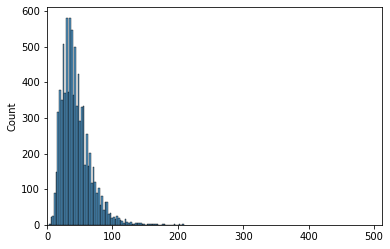

In [ ]:
token_counts = []
for _, row in df_train.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
# Preprocess data
X = list(df_upnsampled["text"])
y = list(df_upnsampled["target_encode"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8)
X_test = list(df_test["text"])
y_test = list(df_test["target_encode"])
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=220)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=220)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=220)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# trainer

In [ ]:
#Saving only the best performing checkpoint
#evaluation_strategy =‘steps’,
#eval_steps = 10, # Evaluation and Save happens every 10 steps
#save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
#load_best_model_at_end=True,
#You can change save_total_limit = 1 so it will serve your purpose

In [ ]:
# Define Trainer parameters
# Here is where the magic of the Trainer function is. We can define the training parameters in the TrainingArguments and Trainer class as well as train the model with a single command.
# We need to first define a function to calculate the metrics of the validation set. Since this is a binary classification problem, we can use accuracy, precision, recall and f1 score.
# Next, we specify some training parameters, set the pretrained model, train data and evaluation data in the TrainingArgs and Trainer class.
# After we have defined the parameters , simply run trainer.train() to train the model.

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_DISABLED'] = 'true'

training_args = TrainingArguments(
    output_dir='feeeback-classifier',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end = True,
    logging_steps= 20,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,
    )
# Train pre-trained model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.266500,2.095229,0.604940,0.604940,0.604940,0.604940
2,1.196400,1.112184,0.773786,0.773786,0.773786,0.773786
3,0.673800,0.682619,0.856157,0.856157,0.856157,0.856157
4,0.431600,0.493383,0.892706,0.892706,0.892706,0.892706


***** Running Evaluation *****
  Num examples = 62874
  Batch size = 32
Saving model checkpoint to feeeback-classifier/checkpoint-984
Configuration saved in feeeback-classifier/checkpoint-984/config.json
Model weights saved in feeeback-classifier/checkpoint-984/pytorch_model.bin
tokenizer config file saved in feeeback-classifier/checkpoint-984/tokenizer_config.json
Special tokens file saved in feeeback-classifier/checkpoint-984/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 62874
  Batch size = 32
Saving model checkpoint to feeeback-classifier/checkpoint-1476
Configuration saved in feeeback-classifier/checkpoint-1476/config.json
Model weights saved in feeeback-classifier/checkpoint-1476/pytorch_model.bin
tokenizer config file saved in feeeback-classifier/checkpoint-1476/tokenizer_config.json
Special tokens file saved in feeeback-classifier/checkpoint-1476/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 62874
  Batch size = 32
Saving mode

In [ ]:
# Create torch dataset
test_dataset = Dataset(X_test_tokenized) 
# Load trained model  , 
model_path = "feeeback-classifier/checkpoint-2770"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=36) 
# model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=df_train["ce"].nunique())
# Define test trainer
test_trainer = Trainer(model) 
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset) 
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

# classification_report

In [ ]:
pred_inverse_transform=le.inverse_transform(y_pred)
test_inverse_transform=le.inverse_transform(y_test)

In [ ]:
# max_length 220  sentence-transformers/all-MiniLM-L6-v2  description non preprocessed
print('\n',classification_report(test_inverse_transform,pred_inverse_transform, zero_division=0))
print("----------------------------------")


                                    precision    recall  f1-score   support

                    antenna issue       0.87      0.93      0.90        14
                     black screen       0.96      0.39      0.55       172
              blocage ots (issue)       0.00      0.00      0.00         0
                        bluetooth       0.00      0.00      0.00         0
               connectivity issue       0.70      0.37      0.48        19
                   display freeze       0.00      0.00      0.00        50
                    display issue       0.07      0.43      0.12         7
                 fuel gauge issue       0.94      0.81      0.87       108
          inductive charger issue       0.50      1.00      0.67         3
                             inex       0.00      0.00      0.00         0
                    inexploitable       0.00      0.00      0.00         8
loss of tactil function on screen       0.00      0.00      0.00         0
                      